In [1]:
import numpy as np
import batman

In [2]:
def transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients

    m = batman.TransitModel(params, time)                #initializes model
    flux = m.light_curve(params)
    t_secondary = m.get_t_secondary(params)
    anom       = m.get_true_anomaly()                    # anom is in radian!
    return flux, t_secondary, anom

def eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients
    params.fp = fp                                       #planet/star brightnes
    params.t_secondary = t_sec
    
    m = batman.TransitModel(params, time, transittype="secondary")  #initializes model
    flux = m.light_curve(params)
    return flux

def area(time, t_sec, per, rp, inc_raw, r2):
    t = time - t_sec
    w = 2*np.pi/per    # orbital angular frequency not to be confused with argumnent of periastron
    phi = (w*t-np.pi)%(2*np.pi)
    inc = inc_raw*np.pi/180 #converting inclination to degrees
    #R = np.array([[np.sin(inc)*np.cos(phi),   np.sin(phi),  np.cos(inc)*np.cos(phi)],
    #              [-np.sin(inc)*np.sin(phi),  np.cos(phi),  -np.cos(inc)*np.sin(phi)],
    #              [-np.cos(inc),              0,            np.sin(inc)]])
    R = np.zeros((len(phi),3,3))
    R[:,0,0] = np.sin(inc)*np.cos(phi)
    R[:,0,1] = np.sin(phi)
    R[:,0,2] = np.cos(inc)*np.cos(phi)
    R[:,1,0] = -np.sin(inc)*np.sin(phi)
    R[:,1,1] = np.cos(phi)
    R[:,1,2] = -np.cos(inc)*np.sin(phi)
    R[:,2,0] = -np.cos(inc)
    R[:,2,2] = np.sin(inc)
    a_mat = np.array([[1/r2**2,  0,        0],
                      [0,        1/rp**2,  0],
                      [0,        0,        1/rp**2]])[np.newaxis,:,:]
    #[[a, d, f],
    # [_, b, e],
    # [_, _, c]] 
    arr = np.matmul(R.transpose(0,2,1), np.matmul(a_mat,R))
    a = arr[:,0,0]
    b = arr[:,1,1]
    c = arr[:,2,2]
    d = arr[:,0,1]
    e = arr[:,1,2]
    f = arr[:,0,2]
    return np.pi/np.sqrt(3*b*f**2/a + 3*c*d**2/a + -6*d*e*f/a + b*c - e**2)/(np.pi*rp**2)

def phase_variation(time, t_sec, per, anom, w, A, B, C, D, mode):
    if 'eccent' in mode:
        phi  = anom + np.deg2rad(w) + np.pi/2      # phis = orbital phase (everything in rad!)
    else:
        t    = time - t_sec
        freq = 2*np.pi/per
        phi  = (freq*t)
    if 'v2' in mode:
        phase = 1 + A*(np.cos(phi)-1) + B*np.sin(phi) + C*(np.cos(2*phi)-1) + D*np.sin(2*phi)
    else:
        phase = 1 + A*(np.cos(phi)-1) + B*np.sin(phi)
    return phase

def fplanet_model(time, anom, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec, A, B, C, D, r2, mode):
    phase = phase_variation(time, t_sec, per, anom, w, A, B, C, D, mode)
    eclip = eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec)
    if 'ellipse' in mode:
        return phase*(eclip - 1)*area(time, t_sec, per, rp, inc, r2)
    else:
        return phase*(eclip - 1)

def ideal_lightcurve(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, r2, mode):
    
    ecc = np.sqrt(ecosw**2 + esinw**2)
    w   = np.rad2deg(np.arctan2(esinw, ecosw))    # needs to be in degrees for batman!
    u1  = 2*np.sqrt(q1)*q2
    u2  = np.sqrt(q1)*(1-2*q2)
    # create transit first and use orbital paramater to get time of superior conjunction
    transit, t_sec, anom = transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2)
    
    #ugly way of doing this as might pick up detector parameters, but thats alright - faster this way and still safe
    fplanet = fplanet_model(time, anom, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec, A, B, C, D, r2, mode)
    
    # add both light curves
    f_total = transit + fplanet
    return f_total



In [3]:
time = np.linspace(56417.2224048537,56420.8356839537, 10000)

mode     = 'Poly2_v1_eccent_psfw'

# Some definition for XO-3b
r_star            = 1.377                    # for XO-3 in solar radius
r_sol2jup         = 0.10049                  # jupiter radius in solar radius
r_sol2AU          = 214.93946938             # AU radius in solar radius

r2=1

# Personalize object default object values
#name = planet                          # name of the planet
    
t0   = 56418.540                       # BMJD time
per  = 3.1915239                       # in days
rp   = 0.125/r_star                    # planetary radius (in solar radius)/stellar radius (solar radius) 
a    = 0.0454*r_sol2AU/r_star          # 
inc  = 84.20                           # 90 = edge-on                
ecosw= 0.277*np.cos(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.cos only takes rad
esinw= 0.277*np.sin(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.sin only takes rad
ecc  = 0
anom = 0
q1   = 0.001
q2   = 0.001
fp   = 0.001                           # eclipse depth in units of stellar flux
    
A    = 0.1
B    = 0.0
C=0.0
D=0.0

u1  = 2*np.sqrt(q1)*q2
u2  = np.sqrt(q1)*(1-2*q2)

ecc = np.sqrt(ecosw**2 + esinw**2)
w   = np.rad2deg(np.arctan2(esinw, ecosw))

In [4]:
from astropy.time import Time
times = ['2013-04-14T04:52:00']
t = Time(times, format='isot', scale='utc')
t.mjd 

array([56396.20277778])

In [5]:
flux = ideal_lightcurve(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, r2, mode)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

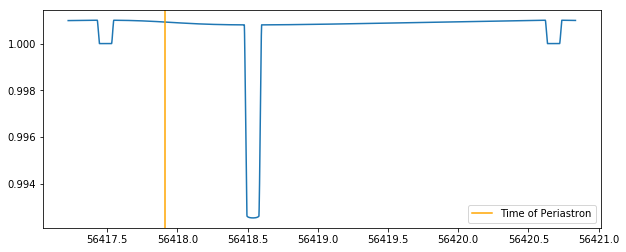

In [7]:
plt.figure(figsize=(10,4))
plt.plot(time, flux)
#plt.axvline(x=56396.20277778)
plt.axvline(x=time[1910], color='orange', label='Time of Periastron')
plt.legend()

In [8]:
tflux, t_secondary, anom = transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2)

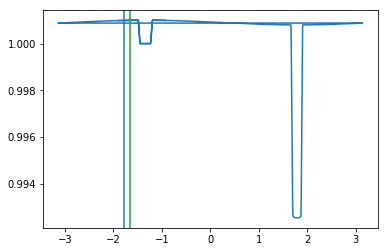

In [9]:
plt.figure()
plt.plot(anom, flux)
plt.axvline(x=anom[190])
plt.axvline(x=anom[363], color='C2')

# Drawing the face-on orbit of XO-3b

In [9]:
from __future__ import print_function, division
import numpy as np
from PyAstronomy import pyasl

In [145]:
a     = 0.0454    # semi-major axis in AU
per   = per       # period in days
ecc   = ecc       # eccentricity
w     = w         # argument of periastron in deg
inc   = 90-84.20    # inclination in deg
lon   = 180        # longitude of ascending node in deg

# creating the keplerian orbit
ke = pyasl.KeplerEllipse(a=a, per=per, e=ecc, Omega=lon, i=inc, w=w)

# Get a time axis
t = np.linspace(0, per, 77)
print('Time interval:', per*24/77, 'hours')

# position in cartisian coordinates
pos = ke.xyzPos(t)
# get center position
cen = ke.xyzCenter()
# get center position
peri = ke.xyzPeriastron()
# get center position
apas = ke.xyzApastron()

Time interval: 0.9947606961038961 hours


In [146]:
# true anomaly of eclipse
fecl = 3*np.pi/2-np.deg2rad(w)
fecl = -np.pi+(fecl-np.pi)

# true anomaly of transit
ftra = np.pi/2-np.deg2rad(w)

# get many time stamp and true anomalies
times = np.linspace(0,per,100000)
f = ke.trueAnomaly(times, ke.eccentricAnomaly(times))

inde = np.argmin(np.abs(f-fecl))
indt = np.argmin(np.abs(f-ftra))

print('Eclipse (values, estimate)', fecl, f[inde])
print('Transit (values, estimate)', ftra, f[indt])

# position as eclispe
ecli = ke.xyzPos(times[inde])
# position as eclispe
tran = ke.xyzPos(times[indt])

Eclipse (values, estimate) -1.347394182539622 -1.3474258045527607
Transit (values, estimate) 1.7941984710501713 1.7941907297749948


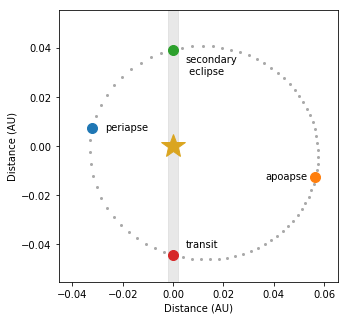

In [147]:
plt.figure(figsize = (5,5))

plt.plot(pos[:,0],pos[:,1], '.', color='darkgray', markersize = 4)
#plt.plot(cen[0], cen[1], 'o', markersize = 10)
plt.plot(peri[0], peri[1], 'o', markersize = 10, label = 'Periastron')
plt.plot(apas[0], apas[1], 'o', markersize = 10, label = 'Apastron')
plt.plot(ecli[0], ecli[1], 'o', markersize = 10, label = 'Eclipse')
plt.plot(tran[0], tran[1], 'o', markersize = 10, label = 'Transit')

plt.text(peri[0]+0.005, peri[1]-0.001, 'periapse', fontdict=None, withdash=False)
plt.text(apas[0]-0.02, apas[1]-0.001, 'apoapse', fontdict=None, withdash=False)
plt.text(ecli[0]+0.005, ecli[1]-0.01, 'secondary\n eclipse', fontdict=None, withdash=False)
plt.text(tran[0]+0.005, tran[1]+0.003, 'transit', fontdict=None, withdash=False)

plt.plot(0, 0, '*', color = 'goldenrod',markersize = 25, label = 'Star')
plt.xlim(-a, a+0.02)
plt.ylim(-a-0.01, a+0.01)
plt.axvspan(-0.002, 0.002, alpha=0.5, color='lightgrey')

plt.xlabel('Distance (AU)')
plt.ylabel('Distance (AU)')

path = 'XO-3b_orbit.pdf'
plt.savefig(path, bbox_inches='tight')

Shape of output array:  (200, 3)
x, y, z for 50th point:  [ 1.12522122 -1.03334057 -0.24875952]


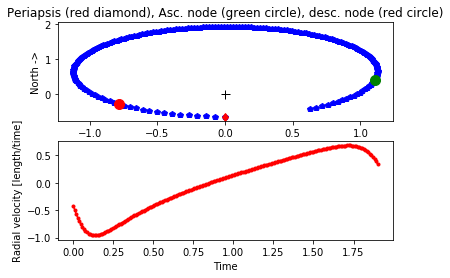

In [63]:
# Instantiate a Keplerian elliptical orbit with
# semi-major axis of 1.3 length units,
# a period of 2 time units, eccentricity of 0.5,
# longitude of ascending node of 70 degrees, an inclination
# of 10 deg, and a periapsis argument of 110 deg.
ke = pyasl.KeplerEllipse(1.3, 2., e=0.5, Omega=70., i=10.0, w=110.0)

# Get a time axis
t = np.linspace(0, 1.9, 200)

# Calculate the orbit position at the given points
# in a Cartesian coordinate system.
pos = ke.xyzPos(t)
print("Shape of output array: ", pos.shape)

# x, y, and z coordinates for 50th time point
print("x, y, z for 50th point: ", pos[50, ::])

# Calculate orbit radius as a function of the
radius = ke.radius(t)

# Calculate velocity on orbit
vel = ke.xyzVel(t)

# Find the nodes of the orbit (Observer at -z)
ascn, descn = ke.xyzNodes_LOSZ()

# Plot x and y coordinates of the orbit
plt.subplot(2,1,1)
plt.title("Periapsis (red diamond), Asc. node (green circle), desc. node (red circle)")
plt.xlabel("East ->")
plt.ylabel("North ->")
plt.plot([0], [0], 'k+', markersize=9)
plt.plot(pos[::,1], pos[::,0], 'bp')
# Point of periapsis
plt.plot([pos[0,1]], [pos[0,0]], 'rd')
# Nodes of the orbit
plt.plot([ascn[1]], [ascn[0]], 'go', markersize=10)
plt.plot([descn[1]], [descn[0]], 'ro', markersize=10)
# Plot RV
plt.subplot(2,1,2)
plt.xlabel("Time")
plt.ylabel("Radial velocity [length/time]")
plt.plot(t, vel[::,2], 'r.-')
plt.show()